In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'
plt.style.use('ggplot') #グラフのスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ設定

df = pd.read_csv("./datasets/fixed_battery_log_2.csv")
df["date"] = pd.to_datetime(df["date"])
users = df["User"].unique()
users

array(['Narita', 'Yusuke', 'Ayumi', 'Daiki', 'Shunya', 'Hayate',
       'Moriyama', 'Isshin'], dtype=object)

In [2]:
df.head()

,User,date,battery,state,weekday,time_to_num
0,Narita,2021-12-04 01:52:00,60,ON,5,6773
1,Narita,2021-12-04 02:22:00,73,OFF,5,8566
2,Narita,2021-12-04 07:06:00,71,ON,5,25564
3,Narita,2021-12-04 07:15:00,73,OFF,5,26105
4,Narita,2021-12-04 07:15:00,73,ON,5,26113


In [2]:
nari = pd.DataFrame(df.loc[(df["User"] == users[2]) & 
            (df["state"] == "ON") & 
                (df["date"] > dt.datetime(2021,12,1)) & 
                    (df["date"] < dt.datetime(2022,2,28))].copy()).set_index(["date"])

In [3]:
nari_BL = pd.DataFrame(nari["battery"].copy())

<AxesSubplot:xlabel='date'>

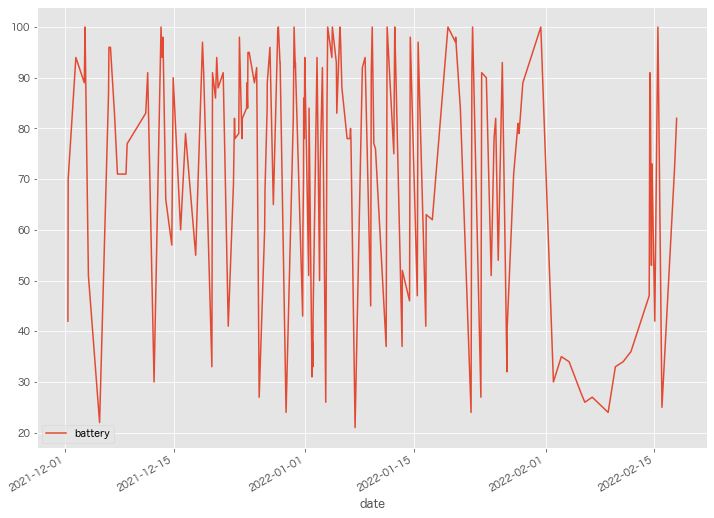

In [4]:
nari_BL.plot()

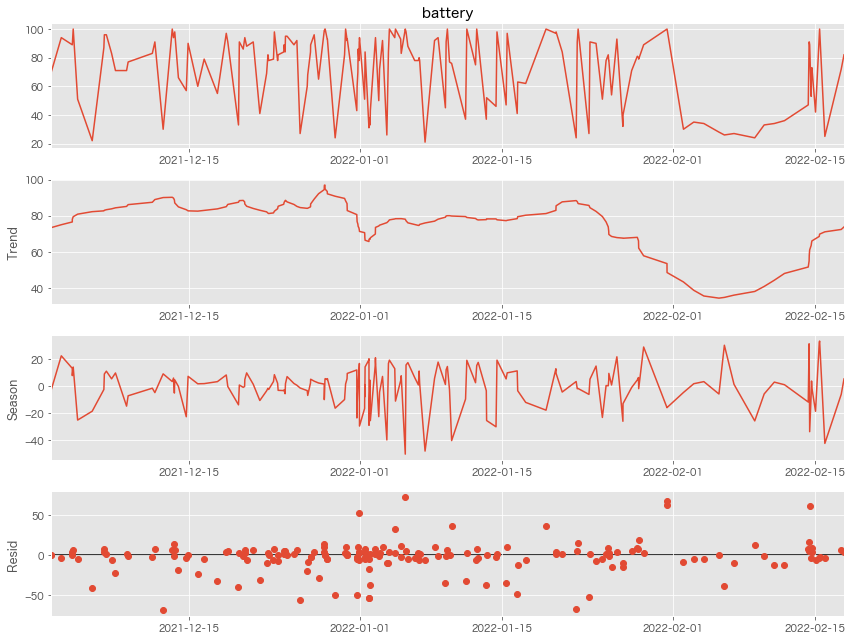

In [5]:
# 成分分解
stl=STL(nari_BL.battery, period=7, robust=True).fit()
stl.plot()
plt.show()

<AxesSubplot:xlabel='date'>

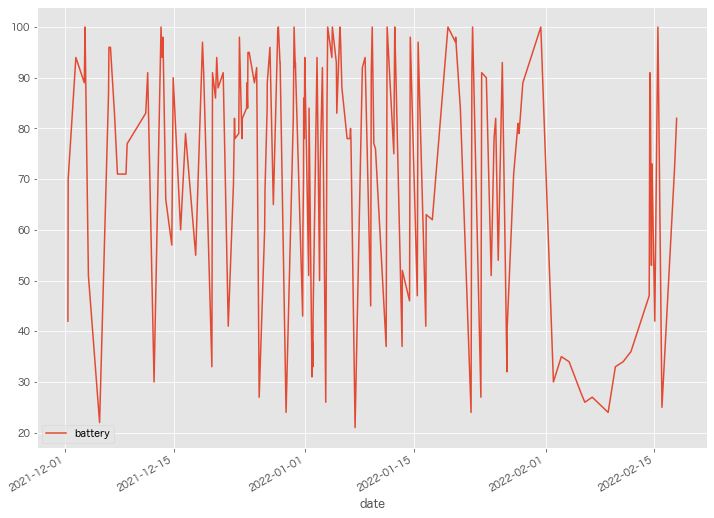

In [6]:
df_log = np.log(nari_BL.battery)
nari_BL.plot()

<AxesSubplot:xlabel='date'>

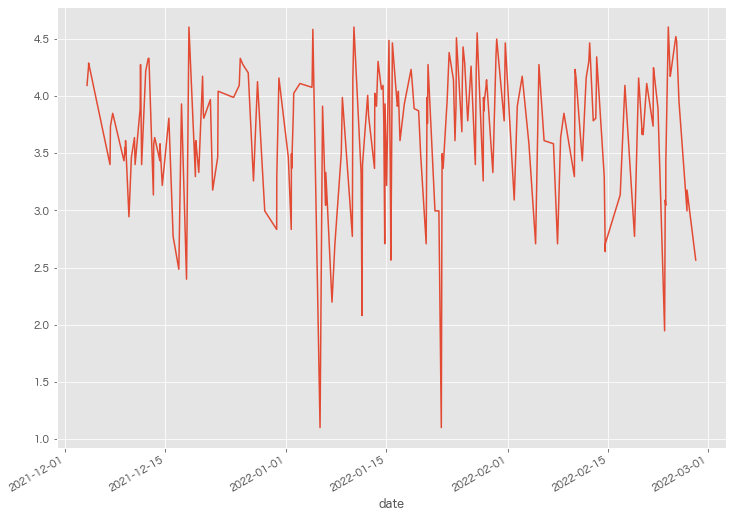

In [8]:
df_log.plot()

In [8]:
# ADF検定（対数系列）
dftest = adfuller(df_log)
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical values :')
for k, v in dftest[4].items():
    print('\t', k, v)

ADF Statistic: -5.538327
p-value: 0.000002
Critical values :
	 1% -3.4672111510631
	 5% -2.877734766803841
	 10% -2.575403364197531


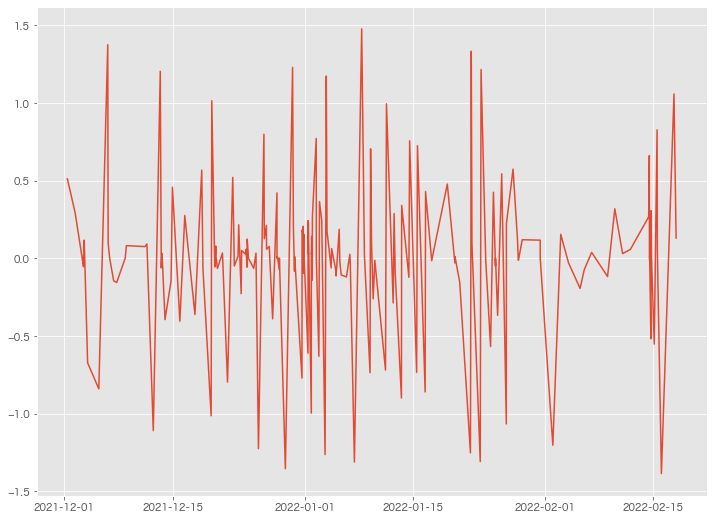

In [9]:
# 階差
df_log_diff1 = df_log.diff(1).dropna()
plt.plot(df_log_diff1)

In [10]:
# ADF検定
dftest = adfuller(df_log_diff1)
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical values :')
for k, v in dftest[4].items():
    print('\t', k, v)

ADF Statistic: -8.509130
p-value: 0.000000
Critical values :
	 1% -3.4680615871598537
	 5% -2.8781061899535128
	 10% -2.5756015922004134


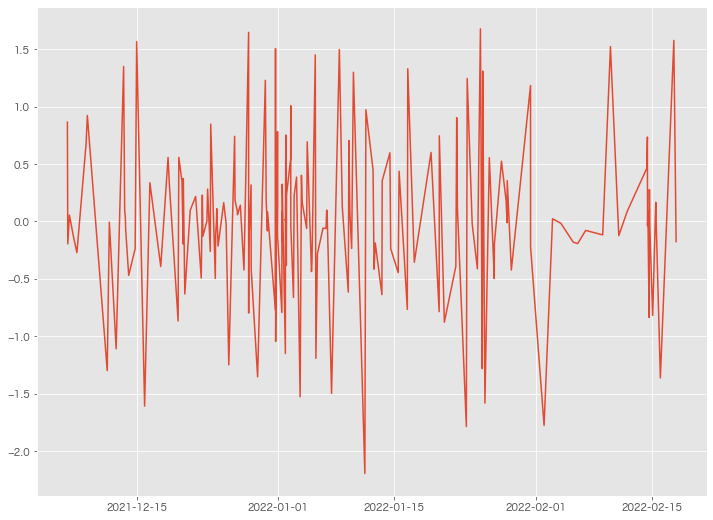

In [11]:
# 季節階差
df_log_diff1_diff12 = df_log_diff1.diff(7).dropna()
plt.plot(df_log_diff1_diff12)

In [12]:
# ADF検定
dftest = adfuller(df_log_diff1_diff12)
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical values :')
for k, v in dftest[4].items():
    print('\t', k, v)

ADF Statistic: -5.461463
p-value: 0.000003
Critical values :
	 1% -3.471633386932248
	 5% -2.8796651107461972
	 10% -2.576433647235832


# コレログラム
***
* 参考資料
    1. [コレグラムとは](https://data-viz-lab.com/correlogram)
    2. [時系列分解手法](https://gri.jp/media/entry/333)
    3. 
* 元のデータxから時間をずらしたデータyとの相関係数を表すグラフであり、横軸にラグ、縦軸に自己相関をとる。
* ラグ
    * 元データからどれほどデータがずれているかを現す指標
* 自己相関
    * ずらしたデータと元データの相関関係を表す指標
![](https://data-viz-lab.com/wp-content/uploads/2021/08/6d871816d00870c315f788a1524e5037.jpg)

* 実際のコレログラムで確認してみると、ラグ12時点の相関係数の値は他の地点と比較して大きい(1に近い)
* つまり、それが一番自己相関係数(-1<x<1)が近い。
* ![](https://data-viz-lab.com/wp-content/uploads/2021/09/02.png)

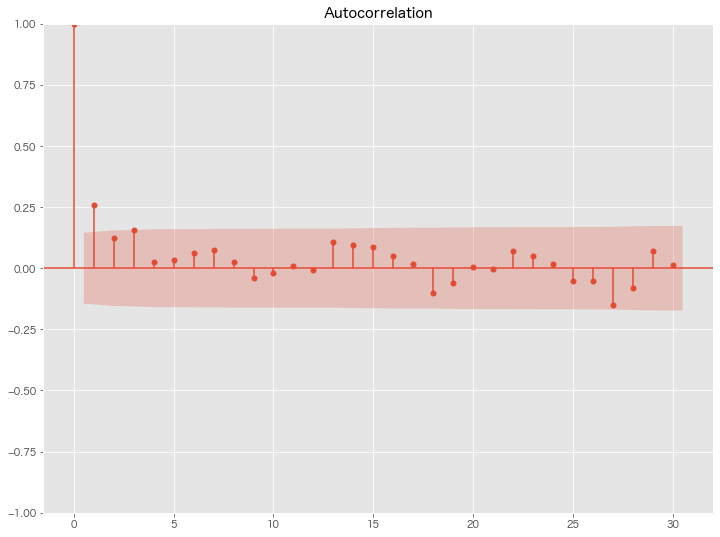

In [13]:
# 自己相関（原系列）
# nari_BL.plot()
acf = plot_acf(nari_BL.battery, lags=30)
# 自己相関（原系列の対数系列の階差系列（次数1））
# acf = plot_acf(np.diff(nari_BL.battery, 1), lags=24)

### Simple Exponential Smoothing model(単純指数平滑化モデル)
* トレンド成分も季節成分もなさそうな時系列データをモデル化する
* 数式で表現すると、時系列データy_1,y_2...に対して、(^ytが予測値)

![](https://cdn.mathpix.com/snip/images/a-Zx1R7-pXU18qQADdLwQU0YXsQ43KOYxwp5WO1GRJ8.original.fullsize.png)

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [15]:
train = nari_BL["2021-12-01":"2022-01-31"]
test = nari_BL["2022-02-01":"2022-02-27"]

In [16]:
# モデルの学習
SES_model = SimpleExpSmoothing(train)
SES_model_fit = SES_model.fit(smoothing_level=0.5)

/Users/isshintoyonaga/.anyenv/envs/pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [19]:
# # テストデータで精度検証
# SES_pred = SES_model_fit.forecast(12) #予測
# print('RMSE:')
# print(np.sqrt(mean_squared_error(test, SES_pred)))
# print('MAE:')
# print(mean_absolute_error(test, SES_pred)) 
# print('MAPE:')
# print(mean_absolute_percentage_error(test, SES_pred))